https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/24714

https://cran.r-project.org/bin/windows/Rtools/rtools42/rtools.html

https://cran.r-project.org/web/packages/Synth/Synth.pdf

https://web.stanford.edu/~jhain/synthpage.html


In [1]:
## Replication Code for
# A. Abadie, A. Diamond, and J. Hainmueller. 2014.
# Comparative Politics and the Synthetic Control Method
# American Journal of Political Science.

rm(list=ls())
library(foreign)
library(Synth)
library(xtable)

##
## Synth Package: Implements Synthetic Control Methods.

## See https://web.stanford.edu/~jhain/synthpage.html for additional information.




In [2]:
# Load Data 
d <- read.dta("repgermany.dta")

In [3]:
## Table 1 & 2, Figure 1, 2, & 3

## pick v by cross-validation
# data setup for training model
dataprep.out <-
  dataprep(
           foo = d,
           predictors    = c("gdp","trade","infrate"),
           dependent     = "gdp",
           unit.variable = 1,
           time.variable = 3,
           special.predictors = list(
            list("industry", 1971:1980, c("mean")),
            list("schooling",c(1970,1975), c("mean")),
            list("invest70" ,1980, c("mean"))
           ),
           treatment.identifier = 7,
           controls.identifier = unique(d$index)[-7],
           time.predictors.prior = 1971:1980,
           time.optimize.ssr = 1981:1990,
           unit.names.variable = 2,
           time.plot = 1960:2003
         )


In [4]:
# fit training model
synth.out <- 
  synth(
        data.prep.obj=dataprep.out,
        Margin.ipop=.005,Sigf.ipop=7,Bound.ipop=6
        )


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 4580.3 

solution.v:
 0.4416242 0.1341865 0.07154372 0.001468537 0.1066766 0.2445004 

solution.w:
 0.1350218 6.08e-08 0.5072797 5.19e-08 4.149e-07 6.59e-08 4.59e-08 2.4e-07 6.33e-08 0.1659215 0.1464772 3.5e-08 2.76e-08 3.24e-08 0.04529688 1.8923e-06 



In [5]:
# data prep for main model
dataprep.out <-
 dataprep(
  foo = d,
  predictors    = c("gdp","trade","infrate"),
  dependent     = "gdp",
  unit.variable = 1,
  time.variable = 3,
  special.predictors = list(
    list("industry" ,1981:1990, c("mean")),
    list("schooling",c(1980,1985), c("mean")),
    list("invest80" ,1980, c("mean"))
  ),
  treatment.identifier = 7,
  controls.identifier = unique(d$index)[-7],
  time.predictors.prior = 1981:1990,
  time.optimize.ssr = 1960:1989,
  unit.names.variable = 2,
  time.plot = 1960:2003
)

# fit main model with v from training model
synth.out <- synth(
  data.prep.obj=dataprep.out,
  custom.v=as.numeric(synth.out$solution.v)
  )


 Missing data: treated unit; special predictor: special.industry.1981.1990 ; for period: 1990 
 We ignore (na.rm = TRUE) all missing values for predictors.op.

X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 optimization over w weights: computing synthtic control unit 
 


**************** 
 v weights supplied manually: computing synthtic control unit 
 


**************** 
**************** 
**************** 

MSPE (LOSS V): 14313.65 

solution.v:
 0.4416242 0.1341865 0.07154372 0.001468537 0.1066766 0.2445004 

solution.w:
 0.2186942 0.0009650622 0.417526 0.001169375 0.001050763 0.0008146782 0.0005029374 0.09028573 0.0005151708 0.1113088 0.1550801 0.0002918853 0.0003029633 0.0005901819 0.0004689689 0.0004332096 



In [6]:
#### Table 2
synth.tables <- synth.tab(
                          dataprep.res = dataprep.out,
                          synth.res = synth.out
                          ); synth.tables
                      
# Replace means for OECD sample (computed externally using proper pop weighting)
synth.tables$tab.pred[,3]          <- c(8021.1,31.9,7.4,34.2,44.1,25.9)
colnames(synth.tables$tab.pred)[3] <- "Rest of OECD Sample"
rownames(synth.tables$tab.pred) <- c("GDP per-capita","Trade openness",
                                     "Inflation rate","Industry share",
                                     "Schooling","Investment rate")

xtable(round(synth.tables$tab.pred,1),digits=1)

#### Table 1
# synth weights
tab1 <- data.frame(synth.tables$tab.w)
tab1[,1] <- round(tab1[,1],2) 
# regression weights
X0 <- cbind(1,t(dataprep.out$X0))
X1 <- as.matrix(c(1,dataprep.out$X1))
W     <- X0%*%solve(t(X0)%*%X0)%*%X1
Wdat  <- data.frame(unit.numbers=as.numeric(rownames(X0)),
                    regression.w=round(W,2))
tab1  <- merge(tab1,Wdat,by="unit.numbers")
tab1  <- tab1[order(tab1[,3]),]

xtable(cbind(tab1[1:9,c(3,2,4)],
             tab1[10:18,c(3,2,4)]
             )
       )

$tab.pred
                              Treated Synthetic Sample Mean
gdp                         15808.900 15802.240   13669.381
trade                          56.778    56.939      59.831
infrate                         2.595     3.495       7.617
special.industry.1981.1990     34.538    34.387      33.794
special.schooling.1980.1985    55.500    55.180      38.659
special.invest80.1980          27.018    27.034      25.895

$tab.v
                            v.weights
gdp                             0.442
trade                           0.134
infrate                         0.072
special.industry.1981.1990      0.001
special.schooling.1980.1985     0.107
special.invest80.1980           0.245

$tab.w
   w.weights  unit.names unit.numbers
1      0.219         USA            1
2      0.001          UK            2
3      0.418     Austria            3
4      0.001     Belgium            4
5      0.001     Denmark            5
6      0.001      France            6
8      0.001       Italy            8
9      0.090 Netherlands            9
10     0.001      Norway           10
12     0.111 Switzerland           12
14     0.155       Japan           14
16     0.000      Greece           16
18     0.000    Portugal           18
19     0.001       Spain           19
20     0.000   Australia           20
21     0.000 New Zealand           21

$tab.loss
          Loss W   Loss V
[1,] 0.002503694 14313.65

,Treated,Synthetic,Rest of OECD Sample
GDP per-capita,15808.9,15802.2,8021.1
Trade openness,56.8,56.9,31.9
Inflation rate,2.6,3.5,7.4
Industry share,34.5,34.4,34.2
Schooling,55.5,55.2,44.1
Investment rate,27.0,27.0,25.9


,unit.names,w.weights,regression.w,unit.names,w.weights,regression.w
15,Australia,0.00,0.12,New Zealand,0.00,0.12
3,Austria,0.42,0.26,Norway,0.00,0.04
4,Belgium,0.00,0.00,Portugal,0.00,-0.08
5,Denmark,0.00,0.08,Spain,0.00,-0.01
6,France,0.00,0.04,Switzerland,0.11,0.05
12,Greece,0.00,-0.09,UK,0.00,0.06
7,Italy,0.00,-0.05,USA,0.22,0.13
11,Japan,0.16,0.19,NA,NA,NA
8,Netherlands,0.09,0.14,NA,NA,NA


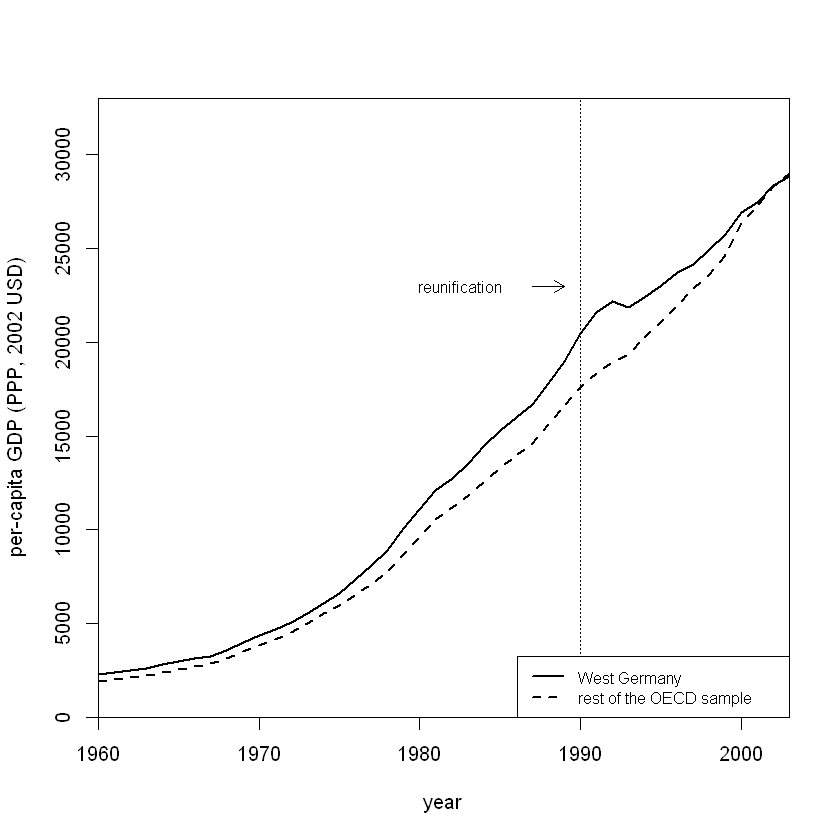

In [7]:
#### Figure 1: Trends in Per-Capita GDP: West Germany vs. Rest of the OECD Sample
Text.height <- 23000
Cex.set <- .8
#pdf(file = "ger_vs_oecd.pdf", width = 5.5, height = 5.5, family = "Times",pointsize = 12)
plot(1960:2003,dataprep.out$Y1plot,
     type="l",ylim=c(0,33000),col="black",lty="solid",
     ylab ="per-capita GDP (PPP, 2002 USD)",
     xlab ="year",
     xaxs = "i", yaxs = "i",
     lwd=2
     )
lines(1960:2003,aggregate(d[,c("gdp")],by=list(d$year),mean,na.rm=T)[,2]
      ,col="black",lty="dashed",lwd=2) # mean 2
abline(v=1990,lty="dotted")
legend(x="bottomright",
       legend=c("West Germany","rest of the OECD sample")
      ,lty=c("solid","dashed"),col=c("black","black")
      ,cex=.8,bg="white",lwd=c(2,2))
arrows(1987,Text.height,1989,Text.height,col="black",length=.1)
text(1982.5,Text.height,"reunification",cex=Cex.set)
#dev.off()

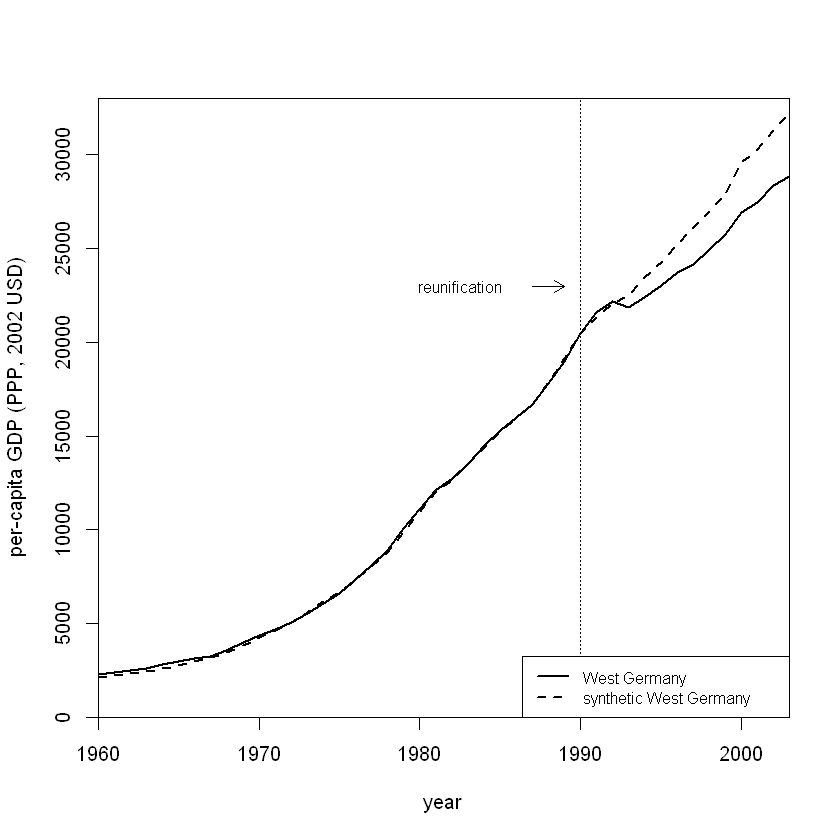

In [8]:
#### Figure 2: Trends in Per-Capita GDP: West Germany vs. Synthetic West Germany
#pdf(file = "ger_vs_synthger2.pdf", width = 5.5, height = 5.5, family = "Times",pointsize = 12)
synthY0 <- (dataprep.out$Y0%*%synth.out$solution.w)
plot(1960:2003,dataprep.out$Y1plot,
     type="l",ylim=c(0,33000),col="black",lty="solid",
     ylab ="per-capita GDP (PPP, 2002 USD)",
     xlab ="year",
     xaxs = "i", yaxs = "i",
     lwd=2
     )
lines(1960:2003,synthY0,col="black",lty="dashed",lwd=2)
abline(v=1990,lty="dotted")
legend(x="bottomright",
       legend=c("West Germany","synthetic West Germany")
      ,lty=c("solid","dashed"),col=c("black","black")
      ,cex=.8,bg="white",lwd=c(2,2))
arrows(1987,Text.height,1989,Text.height,col="black",length=.1)
text(1982.5,Text.height,"reunification",cex=Cex.set)
#dev.off()

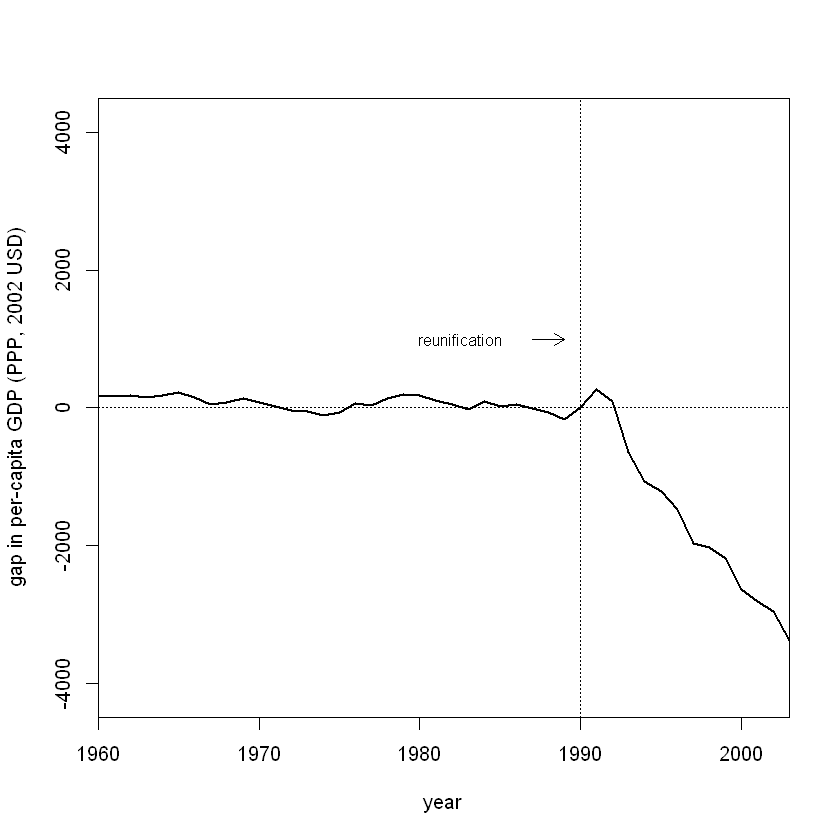

In [9]:
### Figure 3: Per-Capita GDP Gap Between West Germany and Synthetic West Germany
#pdf(file = "ger_vs_synthger_gaps2.pdf", width = 5.5, height = 5.5, family = "Times",pointsize = 12)
gap <- dataprep.out$Y1-(dataprep.out$Y0%*%synth.out$solution.w)
plot(1960:2003,gap,
     type="l",ylim=c(-4500,4500),col="black",lty="solid",
     ylab =c("gap in per-capita GDP (PPP, 2002 USD)"),
     xlab ="year",
     xaxs = "i", yaxs = "i",
     lwd=2
     )
abline(v=1990,lty="dotted")
abline(h=0,lty="dotted")
arrows(1987,1000,1989,1000,col="black",length=.1)
text(1982.5,1000,"reunification",cex=Cex.set)
#dev.off()


 Missing data- treated unit; predictor: infrate ; for period: 1960 
 We ignore (na.rm = TRUE) all missing values for predictors.op.

 Missing data - control unit: 1 ; predictor: infrate ; for period: 1960 
 We ignore (na.rm = TRUE) all missing values for predictors.op.

X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 1137.399 

solution.v:
 0.9278487 0.005475534 0.05653638 0.00156965 0.007457271 0.001112496 

solution.w:
 1.81e-05 1.3743e-06 0.1418765 3.184e-07 7.32e-07 7.821e-07 7.469e-07 2.856e-07 2.224e-07 0.1006167 0.1056345 1.303e-07 1.254e-07 4.046e-07 0.4010984 0.2507507 


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 optimization over w weights: computing synthtic control unit 
 


**************** 
 v weights supplied manually: computing synthtic control unit 
 


**************** 
**************** 
********

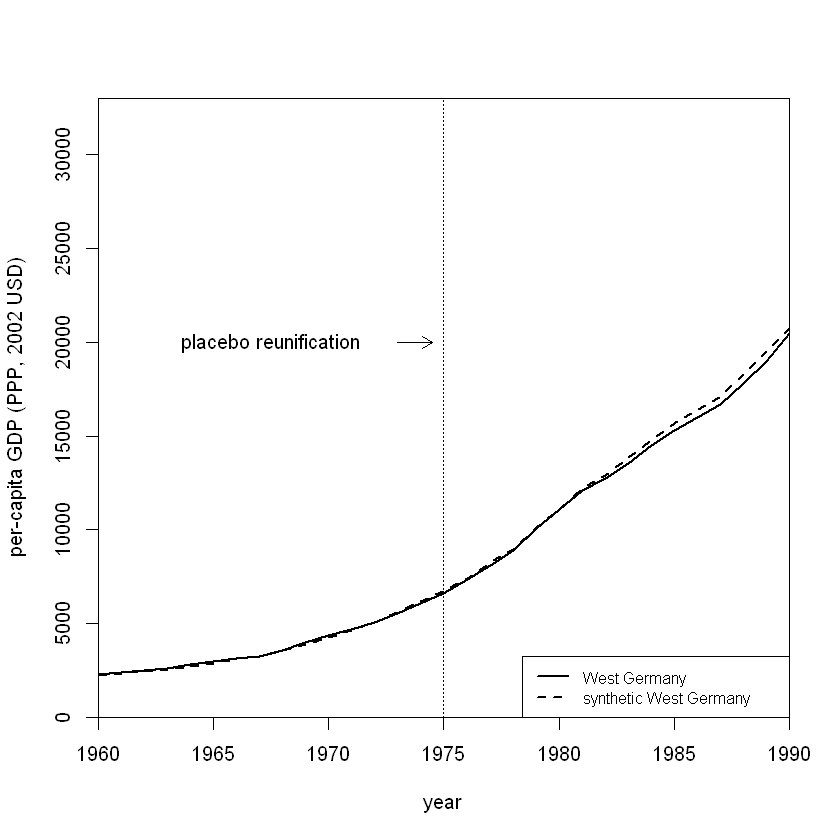

In [10]:
### Figure 4: Placebo Reunification 1975 - Trends in Per-Capita GDP: West Germany vs. Synthetic West Germany

# data prep for training model
dataprep.out <-
  dataprep(
    foo = d,
    predictors    = c("gdp","trade","infrate"),
    dependent     = "gdp",
    unit.variable = 1,
    time.variable = 3,
    special.predictors = list(
      list("industry",1971, c("mean")),
      list("schooling",c(1960,1965), c("mean")),
      list("invest60" ,1980, c("mean"))
    ),
    treatment.identifier = 7,
    controls.identifier = unique(d$index)[-7],
    time.predictors.prior = 1960:1964,
    time.optimize.ssr = 1965:1975,
    unit.names.variable = 2,
    time.plot = 1960:1990
  )

# fit training model
synth.out <- synth(
  data.prep.obj=dataprep.out,
  Margin.ipop=.005,Sigf.ipop=7,Bound.ipop=6
)


# data prep for main model
dataprep.out <-
  dataprep(
    foo = d,
    predictors    = c("gdp","trade","infrate"),
    dependent     = "gdp",
    unit.variable = 1,
    time.variable = 3,
    special.predictors = list(
      list("industry" ,1971:1975, c("mean")),
      list("schooling",c(1970,1975), c("mean")),
      list("invest70" ,1980, c("mean"))
    ),
    treatment.identifier = 7,
    controls.identifier = unique(d$index)[-7],
    time.predictors.prior = 1965:1975,
    time.optimize.ssr = 1960:1975,
    unit.names.variable = 2,
    time.plot = 1960:1990
  )

# fit main model
synth.out <- synth(
  data.prep.obj=dataprep.out,
  custom.v=as.numeric(synth.out$solution.v)
)

Cex.set <- 1
#pdf(file = "2intimeplacebo1975.pdf", width = 5.5, height = 5.5, family = "Times",pointsize = 12)
plot(1960:1990,dataprep.out$Y1plot,
     type="l",ylim=c(0,33000),col="black",lty="solid",
     ylab ="per-capita GDP (PPP, 2002 USD)",
     xlab ="year",
     xaxs = "i", yaxs = "i",
     lwd=2
     )
lines(1960:1990,(dataprep.out$Y0%*%synth.out$solution.w),col="black",lty="dashed",lwd=2)
abline(v=1975,lty="dotted")
legend(x="bottomright",
       legend=c("West Germany","synthetic West Germany")
      ,lty=c("solid","dashed"),col=c("black","black")
      ,cex=.8,bg="white",lwd=c(2,2))
arrows(1973,20000,1974.5,20000,col="black",length=.1)
text(1967.5,20000,"placebo reunification",cex=Cex.set)
#dev.off()

In [11]:
### Figure 5: Ratio of post-reunification RMSPE to pre-reunification RMSPE: West Germany and control countries.

# loop across control units
storegaps <- 
  matrix(NA,
        length(1960:2003),
        length(unique(d$index))-1
        )
rownames(storegaps) <- 1960:2003
i <- 1
co <- unique(d$index)

for(k in unique(d$index)[-7]){
  
  # data prep for training model
  dataprep.out <-
    dataprep(
      foo = d,
      predictors    = c("gdp","trade","infrate"),
      dependent     = "gdp",
      unit.variable = 1,
      time.variable = 3,
      special.predictors = list(
        list("industry",1971:1980, c("mean")),
        list("schooling"   ,c(1970,1975), c("mean")),
        list("invest70" ,1980, c("mean"))
      ),
      treatment.identifier = k,
      controls.identifier = co[-which(co==k)],
      time.predictors.prior = 1971:1980,
      time.optimize.ssr = 1981:1990,
      unit.names.variable = 2,
      time.plot = 1960:2003
    )

  # fit training model
  synth.out <-
   synth(
    data.prep.obj=dataprep.out,
    Margin.ipop=.005,Sigf.ipop=7,Bound.ipop=6
   )

  # data prep for main model
dataprep.out <-
    dataprep(
      foo = d,
      predictors    = c("gdp","trade","infrate"),
      dependent     = "gdp",
      unit.variable = 1,
      time.variable = 3,
      special.predictors = list(
        list("industry" ,1981:1990, c("mean")),
        list("schooling",c(1980,1985), c("mean")),
        list("invest80" ,1980, c("mean"))
      ),
      treatment.identifier = k,
      controls.identifier = co[-which(co==k)],
      time.predictors.prior = 1981:1990,
      time.optimize.ssr = 1960:1989,
      unit.names.variable = 2,
      time.plot = 1960:2003
    )

# fit main model
synth.out <- synth(
   data.prep.obj=dataprep.out,
   custom.v=as.numeric(synth.out$solution.v)
  )

 storegaps[,i] <-  
   dataprep.out$Y1-
   (dataprep.out$Y0%*%synth.out$solution.w)
 i <- i + 1
} # close loop over control units
d <- d[order(d$index,d$year),]
colnames(storegaps) <- unique(d$country)[-7]
storegaps <- cbind(gap,storegaps)
colnames(storegaps)[1] <- c("West Germany")

# compute ratio of post-reunification RMSPE 
# to pre-reunification RMSPE                                                  
rmse <- function(x){sqrt(mean(x^2))}
preloss <- apply(storegaps[1:30,],2,rmse)
postloss <- apply(storegaps[31:44,],2,rmse)

#pdf("2ratio_post_to_preperiod_rmse2a.pdf")
dotchart(sort(postloss/preloss),
         xlab="Post-Period RMSE / Pre-Period RMSE",
         pch=19)
#dev.off()


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 7178.771 

solution.v:
 0.2264173 0.4866822 0.2212707 6.88726e-05 0.001276776 0.06428416 

solution.w:
 1.798e-07 0.3604452 6.53e-08 1.286e-07 7.434e-07 1.162e-07 8.63e-08 7.56e-08 0.2926567 0.2402516 1.296e-07 3.09e-08 1.455e-07 0.1066446 1.324e-07 


 Missing data: treated unit; special predictor: special.industry.1981.1990 ; for period: 1990 
 We ignore (na.rm = TRUE) all missing values for predictors.op.

X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 optimization over w weights: computing synthtic control unit 
 


**************** 
 v weights supplied manually: computing synthtic control unit 
 


**************** 
**************** 
**************** 

MSPE (LOSS V): 45982.62 

solution.v:
 0.2264173 0.4866822 0.2212707 6.88726e-05 0.001276776 0.06428416 

solution.w

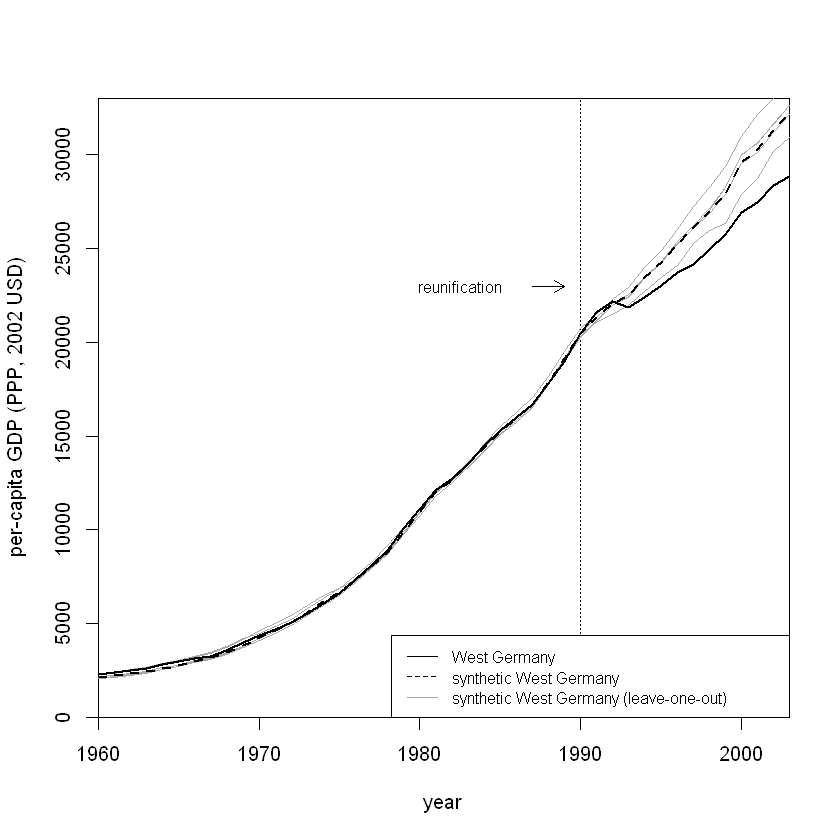

In [20]:
### Figure 6: Leave-one-out distribution of the synthetic control for West Germany

# loop over leave one outs
storegaps <- 
  matrix(NA,
        length(1960:2003),
        5)
colnames(storegaps) <- c(1,3,9,12,14)
co <- unique(d$index)[-7]

for(k in 1:5){

# data prep for training model
omit <- c(1,3,9,12,14)[k]  
  dataprep.out <-
    dataprep(
      foo = d,
      predictors    = c("gdp","trade","infrate"),
      dependent     = "gdp",
      unit.variable = 1,
      time.variable = 3,
      special.predictors = list(
        list("industry",1971:1980, c("mean")),
        list("schooling"   ,c(1970,1975), c("mean")),
        list("invest70" ,1980, c("mean"))
      ),
      treatment.identifier = 7,
      controls.identifier = co[-which(co==omit)],
      time.predictors.prior = 1971:1980,
      time.optimize.ssr = 1981:1990,
      unit.names.variable = 2,
      time.plot = 1960:2003
    )
  
  # fit training model
  synth.out <- synth(
    data.prep.obj=dataprep.out,
    Margin.ipop=.005,Sigf.ipop=7,Bound.ipop=6
  )
  
# data prep for main model
dataprep.out <-
  dataprep(
    foo = d,
    predictors    = c("gdp","trade","infrate"),
    dependent     = "gdp",
    unit.variable = 1,
    time.variable = 3,
    special.predictors = list(
      list("industry" ,1981:1990, c("mean")),
      list("schooling",c(1980,1985), c("mean")),
      list("invest80" ,1980, c("mean"))
    ),
    treatment.identifier = 7,
    controls.identifier = co[-which(co==omit)],
    time.predictors.prior = 1981:1990,
    time.optimize.ssr = 1960:1989,
    unit.names.variable = 2,
    time.plot = 1960:2003
  )
  
  # fit main model 
  synth.out <- synth(
    data.prep.obj=dataprep.out,
    custom.v=as.numeric(synth.out$solution.v)
  )
  storegaps[,k] <- (dataprep.out$Y0%*%synth.out$solution.w)
} # close loop over leave one outs

Text.height <- 23000
Cex.set <- .8
#pdf(file = "1jackknife2.pdf", width = 5.5, height = 5.5, family = "Times",pointsize = 12)
plot(1960:2003,dataprep.out$Y1plot,
     type="l",ylim=c(0,33000),col="black",lty="solid",
     ylab ="per-capita GDP (PPP, 2002 USD)",
     xlab ="year",
     xaxs = "i", yaxs = "i",lwd=2
     )

abline(v=1990,lty="dotted")
arrows(1987,23000,1989,23000,col="black",length=.1)
 for(i in 1:5){
  lines(1960:2003,storegaps[,i],col="darkgrey",lty="solid")
  }
lines(1960:2003,synthY0,col="black",lty="dashed",lwd=2)
lines(1960:2003,dataprep.out$Y1plot,col="black",lty="solid",lwd=2)
text(1982.5,23000,"reunification",cex=.8)
legend(x="bottomright",
       legend=c("West Germany",
                "synthetic West Germany",
                "synthetic West Germany (leave-one-out)")
      ,lty=c("solid","dashed","solid"),
      col=c("black","black","darkgrey")
      ,cex=.8,bg="white",lwdc(2,2,1))
#dev.off()

In [22]:
install.packages('gtools')


  There is a binary version available but the source version is later:
       binary source needs_compilation
gtools  3.8.2  3.9.5              TRUE

  Binaries will be installed
package 'gtools' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\War\AppData\Local\Temp\Rtmp2Bd5wR\downloaded_packages


In [23]:
## Table 3: Synthetic Weights from Combinations of Control Countries
rm(list=ls())
library(gtools)
library(kernlab)

# data prep for training model
d <- read.dta("repgermany.dta")
dataprep.out <-
  dataprep(
    foo = d,
    predictors    = c("gdp","trade","infrate"),
    dependent     = "gdp",
    unit.variable = 1,
    time.variable = 3,
    special.predictors = list(
      list("industry", 1971:1980, c("mean")),
      list("schooling",c(1970,1975), c("mean")),
      list("invest70" ,1980, c("mean"))
    ),
    treatment.identifier = 7,
    controls.identifier = unique(d$index)[-7],
    time.predictors.prior = 1971:1980,
    time.optimize.ssr = 1981:1990,
    unit.names.variable = 2,
    time.plot = 1960:2003
  )

# fit training model
synth.out <- 
  synth(
    data.prep.obj=dataprep.out,
    Margin.ipop=.005,Sigf.ipop=7,Bound.ipop=6
  )

# data prep for main model
dataprep.out <-
  dataprep(
    foo = d,
    predictors    = c("gdp","trade","infrate"),
    dependent     = "gdp",
    unit.variable = 1,
    time.variable = 3,
    special.predictors = list(
      list("industry" ,1981:1990, c("mean")),
      list("schooling",c(1980,1985), c("mean")),
      list("invest80" ,1980, c("mean"))
    ),
    treatment.identifier = 7,
    controls.identifier = unique(d$index)[-7],
    time.predictors.prior = 1981:1990,
    time.optimize.ssr = 1960:1989,
    unit.names.variable = 2,
    time.plot = 1960:2003
  )

# fit main model with v from training model
synth.out <- synth(
  data.prep.obj=dataprep.out,
  custom.v=as.numeric(synth.out$solution.v)
)

synth.tables <- synth.tab(
  dataprep.res = dataprep.out,
  synth.res = synth.out
)

table3 <- list()
synth.tables$tab.w[,1] <- round(synth.tables$tab.w[,1],2)
table3[[5]] <-synth.tables$tab.w[order(-1*synth.tables$tab.w[,1]),2:1][1:5,]

# compute loss for all combinations 
# of 4, 3, 2, 1 sized donor pools

# get W and v
solution.w <- round(synth.out$solution.w,3)
V <- diag(as.numeric(synth.out$solution.v))

# compute scaled Xs
nvarsV <- dim(dataprep.out$X0)[1]
big.dataframe <- cbind(dataprep.out$X0, dataprep.out$X1)
divisor <- sqrt(apply(big.dataframe, 1, var))
scaled.matrix <-
  t(t(big.dataframe) %*% ( 1/(divisor) *
  diag(rep(dim(big.dataframe)[1], 1)) ))
X0.scaled <- scaled.matrix[,c(1:(dim(dataprep.out$X0)[2]))]
X1.scaled <- as.matrix(scaled.matrix[,dim(scaled.matrix)[2]])

dn <- d[d$year==1970,c("country","index")]
dn <- dn[order(dn$index),]
dn <- dn[-7,]

table2store <- matrix(NA,nrow(dataprep.out$X1),4)
fig7store   <- matrix(NA,length(1960:2003),4)  

# loop through number of controls
for(pp in 4:1){
  store       <- combinations(length(unique(d$index)[-7]),
                              r=pp, v=unique(d$index)[-7])
  store.loss  <- matrix(NA,nrow=nrow(store),1)
  store.w     <- matrix(NA,nrow=nrow(store),pp)
  store.c     <- store.w

# loop through combinations 
  for(k in 1:nrow(store)){
    # index positions of control units
    posvector <- c()
    for(i in 1:pp){
      posvector <- c(posvector,which(dn$index==store[k,i]))
    }
    
  # run quad optimization  
    X0temp <- X0.scaled[ , posvector ]
    H <- t(X0temp) %*% V %*% (X0temp)
    c <- -1*c(t(X1.scaled) %*% V %*% (X0temp) )

    if(pp == 1){
      solution.w <- matrix(1)
    } else {      
        res <- ipop(c = c, H = H, A = t(rep(1, length(c))),
                    b = 1, l = rep(0, length(c)),
                    u = rep(1, length(c)), r = 0,
                    margin = 0.005,sigf = 7, bound = 6)
        solution.w <- as.matrix(primal(res))
    }
    loss.w <- t(X1.scaled - X0temp %*% solution.w) %*% V %*% (X1.scaled - X0temp %*% solution.w)
    
    store.loss[k] <- loss.w
    store.w[k,]   <- t(solution.w)
    store.c[k,]   <- dn$country[posvector]
  } # close loop over combinations
  
# get best fitting combination
  dat <- data.frame(store.loss,
                    store,
                    store.c,
                    store.w
                    )
  colnames(dat) <- c("loss",
                     paste("CNo",1:pp,sep=""),
                     paste("CNa",1:pp,sep=""),
                     paste("W",1:pp,sep="")
                     )
  dat <- dat[order(dat$loss),]
  Countries <- dat[1,paste("CNo",1:pp,sep="")]
  Cweights  <- as.numeric(dat[1,paste("W",1:pp,sep="")])
 
  outdat <-  data.frame(unit.names=as.vector(
   (t(as.vector(dat[1,paste("CNa",1:pp,sep="")])))),
                    w.weights=round(Cweights,2))

table3[[pp]]<- outdat[order(-1*outdat$w.weights),]
  
 # get posvector for fitting
  posvector <- c()
  if(pp == 1 ){
    posvector <- c(posvector,which(dn$index==Countries))
  } else {
    for(i in 1:pp){
      posvector <- c(posvector,which(dn$index==Countries[1,i]))
    }
  }
   
  X0t <- as.matrix(dataprep.out$X0[,posvector])%*% as.matrix(Cweights)
  table2store[,(4:1)[pp]] <- X0t

  fig7store[,(4:1)[pp]] <- 
   dataprep.out$Y0[,posvector]%*%as.matrix(Cweights)

} # close loop over number of countries

# Table 3
table3

# Table 4
synth.tables$tab.pred[,3] <- c(8021.1,31.9,7.4,34.2,44.1,25.9)
table4 <- round(
  cbind(synth.tables$tab.pred[,1:2],
        table2store,
        synth.tables$tab.pred[,3]),1)
rownames(table4) <- c("GDP per-capita","Trade openness",
                      "Inflation rate","Industry share",
                      "Schooling","Investment rate")
colnames(table4)[2:7] <- c(5:1,"OECD Sample")
table4

Warning message:
"package 'gtools' was built under R version 3.6.3"


X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 searching for synthetic control unit  
 

**************** 
**************** 
**************** 

MSPE (LOSS V): 4580.3 

solution.v:
 0.4416242 0.1341865 0.07154372 0.001468537 0.1066766 0.2445004 

solution.w:
 0.1350218 6.08e-08 0.5072797 5.19e-08 4.149e-07 6.59e-08 4.59e-08 2.4e-07 6.33e-08 0.1659215 0.1464772 3.5e-08 2.76e-08 3.24e-08 0.04529688 1.8923e-06 


 Missing data: treated unit; special predictor: special.industry.1981.1990 ; for period: 1990 
 We ignore (na.rm = TRUE) all missing values for predictors.op.

X1, X0, Z1, Z0 all come directly from dataprep object.


**************** 
 optimization over w weights: computing synthtic control unit 
 


**************** 
 v weights supplied manually: computing synthtic control unit 
 


**************** 
**************** 
**************** 

MSPE (LOSS V): 14313.65 

solution.v:
 0.4416242 0.1341865 0.07154372 0.001468537 0.1066766 0.2445004 

solution.w:

[[1]]
  unit.names w.weights
1    Austria         1

[[2]]
  unit.names w.weights
2    Austria      0.76
1        USA      0.24

[[3]]
  unit.names w.weights
2    Austria      0.59
1        USA      0.26
3      Japan      0.15

[[4]]
   unit.names w.weights
2     Austria      0.56
1         USA      0.22
4       Japan      0.12
3 Switzerland      0.10

[[5]]
    unit.names w.weights
3      Austria      0.42
1          USA      0.22
14       Japan      0.16
12 Switzerland      0.11
9  Netherlands      0.09

,Treated,5,4,3,2,1,OECD Sample
GDP per-capita,15808.9,15802.2,15800.9,15492.9,15580.9,14817.0,8021.1
Trade openness,56.8,56.9,55.9,52.5,61.5,74.6,31.9
Inflation rate,2.6,3.5,3.6,3.6,3.8,3.5,7.4
Industry share,34.5,34.4,34.6,34.8,34.3,35.5,34.2
Schooling,55.5,55.2,57.6,57.7,60.7,60.9,44.1
Investment rate,27.0,27.0,27.2,26.8,25.6,26.6,25.9


[[1]]
  unit.names w.weights
1    Austria         1

[[2]]
  unit.names w.weights
2    Austria      0.76
1        USA      0.24

[[3]]
  unit.names w.weights
2    Austria      0.59
1        USA      0.26
3      Japan      0.15

[[4]]
   unit.names w.weights
2     Austria      0.56
1         USA      0.22
4       Japan      0.12
3 Switzerland      0.10

[[5]]
    unit.names w.weights
3      Austria      0.42
1          USA      0.22
14       Japan      0.16
12 Switzerland      0.11
9  Netherlands      0.09

,Treated,5,4,3,2,1,OECD Sample
GDP per-capita,15808.9,15802.2,15800.9,15492.9,15580.9,14817.0,8021.1
Trade openness,56.8,56.9,55.9,52.5,61.5,74.6,31.9
Inflation rate,2.6,3.5,3.6,3.6,3.8,3.5,7.4
Industry share,34.5,34.4,34.6,34.8,34.3,35.5,34.2
Schooling,55.5,55.2,57.6,57.7,60.7,60.9,44.1
Investment rate,27.0,27.0,27.2,26.8,25.6,26.6,25.9


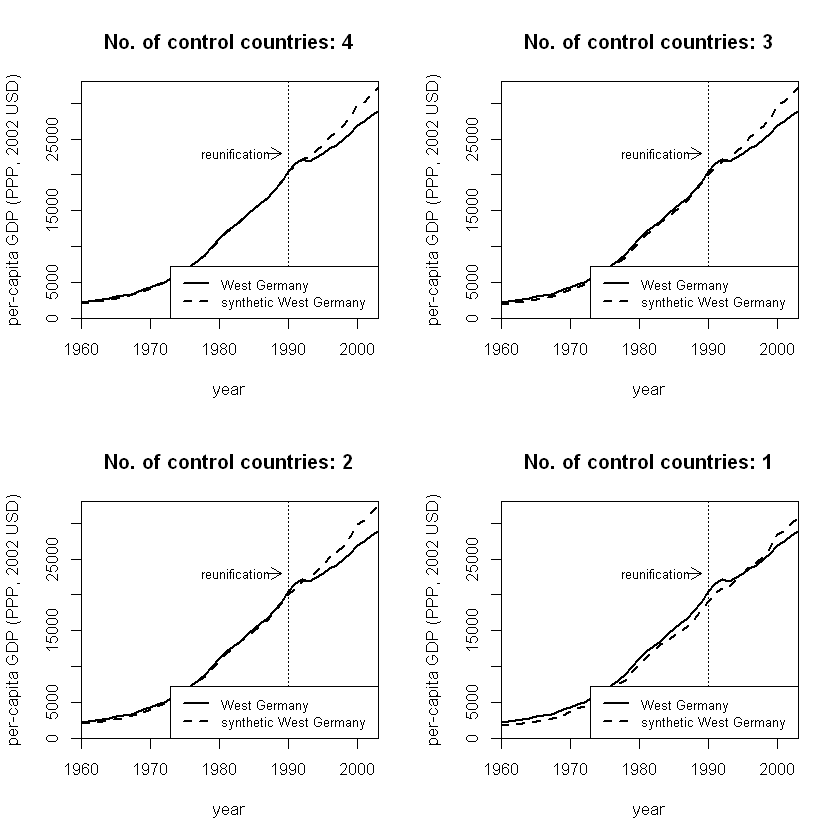

In [24]:
# Table 3
table3

# Table 4
synth.tables$tab.pred[,3] <- c(8021.1,31.9,7.4,34.2,44.1,25.9)
table4 <- round(
  cbind(synth.tables$tab.pred[,1:2],
        table2store,
        synth.tables$tab.pred[,3]),1)
rownames(table4) <- c("GDP per-capita","Trade openness",
                      "Inflation rate","Industry share",
                      "Schooling","Investment rate")
colnames(table4)[2:7] <- c(5:1,"OECD Sample")
table4

## Figure 7: Per-Capita GDP Gaps Between West Germany and Sparse Synthetic Controls
Text.height <- 23000
Cex.set <- .8

par(mfrow=c(2,2)) 
for(pp in 4:1){
#pdf(file = paste("2ger_vs_synth","CValt",pp,".pdf",sep=""), width = 5.5, height = 5.5, family = "Times",pointsize = 12)
  plot(1960:2003,dataprep.out$Y1,
       type="l",ylim=c(0,33000),col="black",lty="solid",
       ylab ="per-capita GDP (PPP, 2002 USD)",
       xlab ="year",
       xaxs = "i", yaxs = "i",
       lwd=2,
       main=paste("No. of control countries: ",pp,sep="")
       )
  lines(1960:2003,fig7store[,c(4:1)[pp]],col="black",lty="dashed",lwd=2)
  abline(v=1990,lty="dotted")
  legend(x="bottomright",
         legend=c("West Germany","synthetic West Germany")
         ,lty=c("solid","dashed"),col=c("black","black")
         ,cex=.8,bg="white",lwd=c(2,2))
  arrows(1987,Text.height,1989,Text.height,col="black",length=.1)
  text(1982.5,Text.height,"reunification",cex=Cex.set)
  #dev.off()
}
